### Importing Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sms
import warnings
import itertools

%matplotlib inline

### Data Preprocessing

In [2]:
df = pd.read_csv(r'C:\Users\Admin\Desktop\Project\dataset\dengue08.csv')
df['date'] = pd.to_datetime(df['date'])
df.tail()

,date,cases
187,2023-08-01,71976
188,2023-09-01,79598
189,2023-10-01,67769
190,2023-11-01,40716
191,2023-12-01,9288


In [3]:
df.isnull().sum()

date     0
cases    0
dtype: int64

In [4]:
df.set_index('date', inplace=True)

### HWES Model

In [5]:
# Set the frequency of the DateTime index
df.index.freq = 'MS'

In [6]:
plt.rcParams.update({'font.size': 11})

#### The zero values need slight modification when seasonal='mul'

In [7]:
# Find the smallest value in the dataset
min_val = df['cases'].min()

# If the smallest value is less than or equal to 0, add a constant to make all values positive
if min_val <= 0:
    constant_to_add = abs(min_val) + 1  # The "+1" ensures all values are strictly positive
    df['cases'] = df['cases'] + constant_to_add

C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


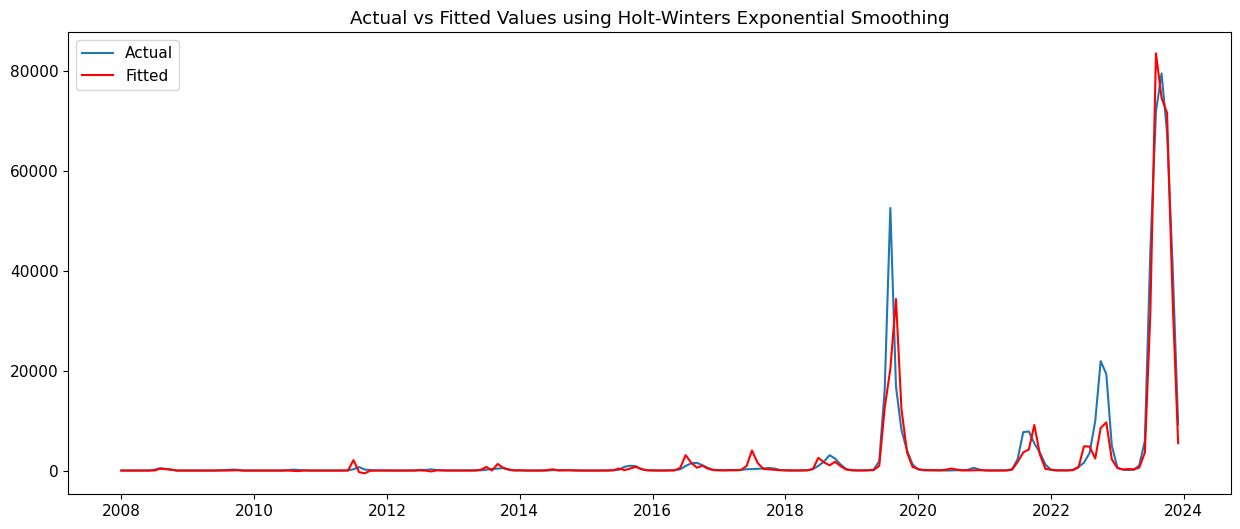

In [8]:
# Fit the HWES model with multiplicative seasonality
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model_hwes = ExponentialSmoothing(df['cases'], trend='add', seasonal='mul', seasonal_periods=12)
fit_hwes = model_hwes.fit(method='basinhopping')

# Get the fitted values
fitted_values_hwes = fit_hwes.fittedvalues

# Plotting the actual vs fitted values
plt.figure(figsize=(15, 6))
plt.plot(df['cases'], label='Actual')
plt.plot(fitted_values_hwes, label='Fitted', color='red')
plt.title('Actual vs Fitted Values using Holt-Winters Exponential Smoothing')
plt.legend()
plt.show()

#### Evaluating the model

In [9]:
#Calculate MAE
from sklearn.metrics import mean_absolute_error
# Calculate the Mean Absolute Error (MAE) between the actual and fitted values
mae_hwes = mean_absolute_error(df['cases'], fitted_values_hwes)
print(f'MAE: {mae_hwes}')

# Calculate RMSE
from sklearn.metrics import mean_squared_error

rmse_hwes = np.sqrt(mean_squared_error(df['cases'], fitted_values_hwes))
print(f'RMSE: {rmse_hwes}')

MAE: 963.8650312015293
RMSE: 3389.6221413954613


#### Forecast with CI

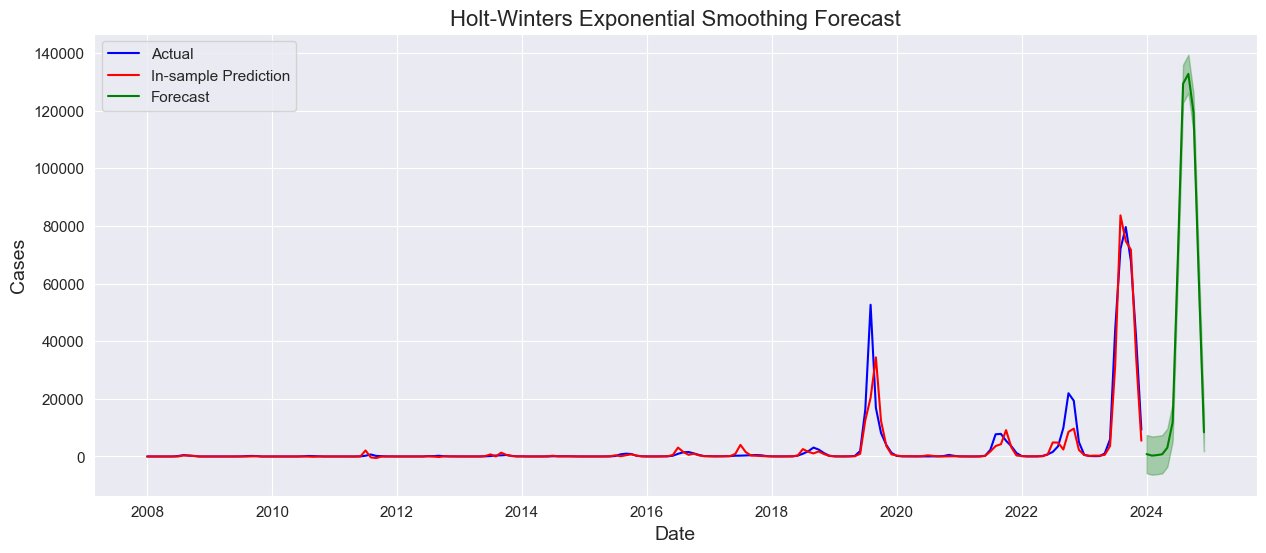

In [10]:
# Creating a new date range for the forecast period
forecast_index = pd.date_range(start='2024-01-01', periods=12, freq='MS')

# Forecasting for the year 2024 (12 months ahead)
forecast_values = fit_hwes.forecast(steps=12)

# Manually calculating the confidence intervals based on the residuals' standard deviation
residual_std = fit_hwes.resid.std()
conf_int = pd.concat([
    forecast_values - 1.96 * residual_std,
    forecast_values + 1.96 * residual_std
], axis=1)
conf_int.columns = ['Lower_CI', 'Upper_CI']

# Creating a DataFrame to hold the forecast values and confidence intervals
forecast_df = pd.DataFrame({
    'Forecast': forecast_values
}, index=forecast_index)

# Merging the confidence intervals
forecast_df = pd.concat([forecast_df, conf_int], axis=1)

# Plotting the actual, fitted, and forecasted values along with confidence intervals
sns.set_style("darkgrid")

plt.figure(figsize=(15, 6))
plt.plot(df['cases'], label='Actual', color='blue')
plt.plot(fitted_values_hwes, label='In-sample Prediction', color='red')
plt.plot(forecast_df['Forecast'], label='Forecast', color='green')
plt.fill_between(forecast_df.index, forecast_df['Lower_CI'], forecast_df['Upper_CI'], color='green', alpha=0.3)
plt.title('Holt-Winters Exponential Smoothing Forecast',fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cases', fontsize=14)
plt.legend()

plt.savefig("007.hwes_multiplicative_forecast.png", bbox_inches='tight')

plt.show()

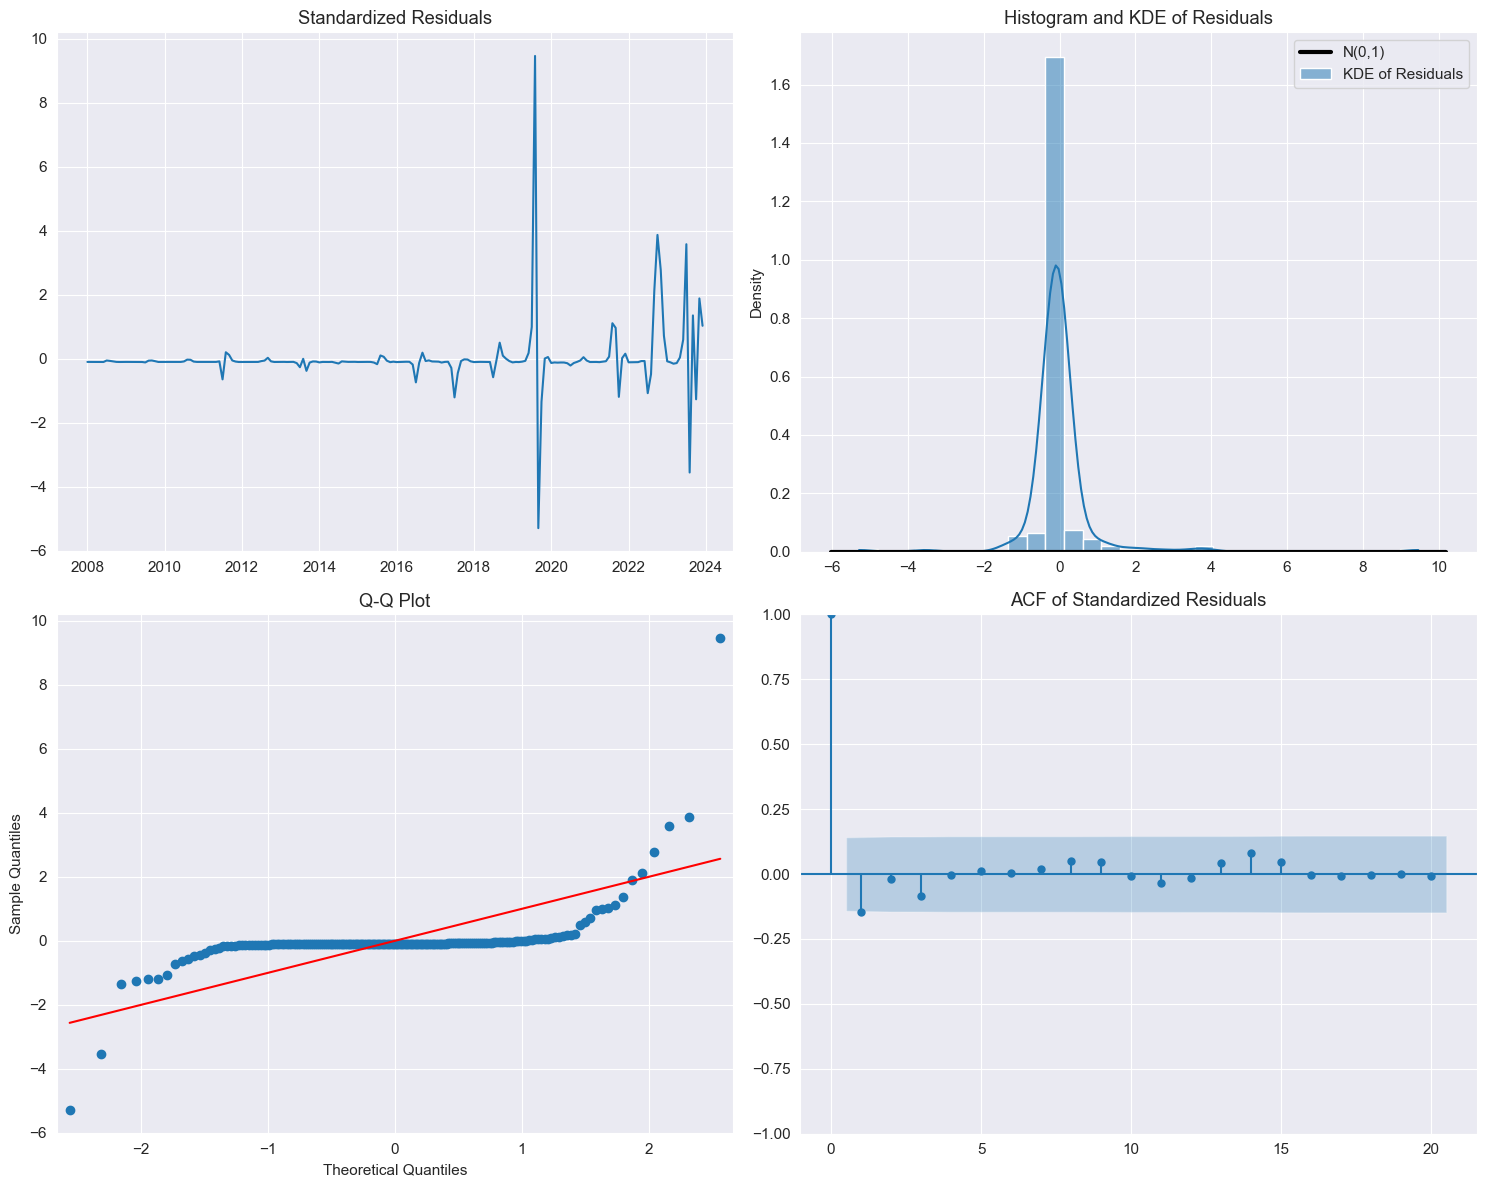

In [11]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore, norm
from scipy import stats


def hwes_diagnostics(residuals, lags=20):
    """
    Plot diagnostics for HWES residuals.
    """
    # Standardizing residuals
    std_residuals = zscore(fit_hwes.resid)
    
    # Creating subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plotting standardized residuals
    axes[0, 0].plot(std_residuals)
    axes[0, 0].set_title('Standardized Residuals')
    
    # Histogram and KDE
    sns.histplot(std_residuals, kde=True, stat='density', bins=30, ax=axes[0, 1], label='KDE of Residuals')
    xmin, xmax = axes[0, 1].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, np.mean(residuals), np.std(residuals))
    axes[0, 1].plot(x, p, 'k', linewidth=3, label='N(0,1)')
    axes[0, 1].set_title('Histogram and KDE of Residuals')
    axes[0, 1].legend()  # Displaying the legend
    
    # Plotting Q-Q plot
    sm.qqplot(std_residuals, line='s', ax=axes[1, 0])
    axes[1, 0].set_title('Q-Q Plot')
    
    # Plotting ACF
    sm.graphics.tsa.plot_acf(std_residuals, lags=lags, ax=axes[1, 1])
    axes[1, 1].set_title('ACF of Standardized Residuals')
    
    plt.tight_layout()
    plt.show()

# Applying the function to the residuals of your model
hwes_diagnostics(fit_hwes.resid)


In [12]:
# Displaying the forecasted values along with confidence intervals
forecast_df

,Forecast,Lower_CI,Upper_CI
2024-01-01,826.016495,-5804.359789,7456.392780
2024-02-01,303.167402,-6327.208882,6933.543687
2024-03-01,469.811485,-6160.564799,7100.187770
2024-04-01,773.032695,-5857.343589,7403.408980
2024-05-01,3047.811011,-3582.565273,9678.187296
2024-06-01,11879.968284,5249.591999,18510.344568
2024-07-01,67961.399695,61331.023411,74591.775979
2024-08-01,129307.370786,122676.994501,135937.747070
2024-09-01,132735.696542,126105.320257,139366.072826
2024-10-01,119331.012846,112700.636562,125961.389130


#### Ljung-Box Test

In [13]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals_hwes = df['cases'] - fitted_values_hwes

# Perform the Ljung-Box test
ljung_box_results = acorr_ljungbox(residuals_hwes, lags=12)

# Directly print the results
print("Ljung-Box test results:")
print(ljung_box_results)

Ljung-Box test results:
     lb_stat  lb_pvalue
1   4.170722   0.041128
2   4.251555   0.119340
3   5.637715   0.130630
4   5.639056   0.227774
5   5.675185   0.339118
6   5.675974   0.460448
7   5.744411   0.569890
8   6.234420   0.620992
9   6.663241   0.672134
10  6.677427   0.755506
11  6.897363   0.807333
12  6.952962   0.860706


The p-values are above 0.05 for all lags, suggesting that there is no significant autocorrelation in the residuals at lags 1 through 12.

#### Residual Analysis

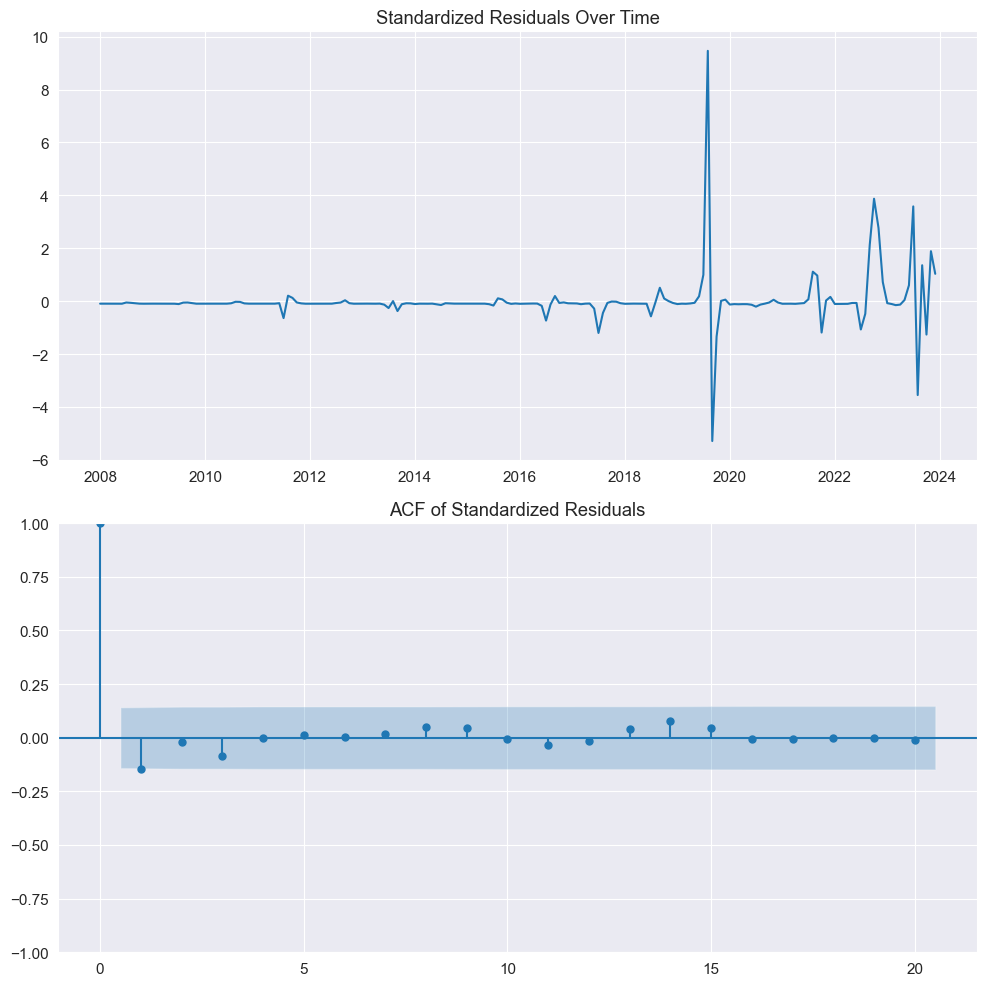

<Figure size 640x480 with 0 Axes>

In [14]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import zscore

def plot_residuals_and_acf(residuals, lags=20):
    """
    Plot standardized residuals over time and ACF for standardized residuals.
    """
    # Standardizing residuals
    std_residuals = zscore(residuals)
    
    # Creating subplots
    fig, axes = plt.subplots(2, 1, figsize=(10, 10))
    
    # Plot standardized residuals over time
    axes[0].plot(std_residuals)
    axes[0].set_title('Standardized Residuals Over Time')
    
    # Plotting ACF of standardized residuals
    sm.graphics.tsa.plot_acf(std_residuals, lags=lags, ax=axes[1])
    axes[1].set_title('ACF of Standardized Residuals')
    
    plt.tight_layout()
    plt.show()

plot_residuals_and_acf(fit_hwes.resid)

plt.savefig("008.hwes_residuals.png", bbox_inches='tight')
